In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

In [90]:
df_drugs = pd.read_csv("drugs.csv")
df_drugs.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [91]:
df_drugs.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [92]:
# Objeto LabelEncoder y diccionario con las caracteristicas para la documentacion.
le = preprocessing.LabelEncoder()
Scaler = preprocessing.StandardScaler()

mapeoCaracteristicas= {}
mapeoCaracteristicaDrug={}

In [93]:
# Etiquetar las columnas y guardar los mapeos
for columna in ['BP', 'Sex', 'Cholesterol']:
    #Se utiliza label encoder para cambiar strings por valores numericos
    df_drugs[columna] = le.fit_transform(df_drugs[columna])
    mapeoCaracteristicas[columna] = dict(zip(le.classes_, le.transform(le.classes_)))

mapeoCaracteristicas

{'BP': {'HIGH': 0, 'LOW': 1, 'NORMAL': 2},
 'Sex': {'F': 0, 'M': 1},
 'Cholesterol': {'HIGH': 0, 'NORMAL': 1}}

In [94]:
#Creacion de variables para el entrenamiento y test.
x_ind=df_drugs.drop("Drug", axis=1)
y_dep=pd.DataFrame(df_drugs["Drug"])

In [95]:
y_dep_array = y_dep.values.ravel()
y_dep_array[:5]

array(['drugY', 'drugC', 'drugC', 'drugX', 'drugY'], dtype=object)

In [96]:
#Transformamos etiquetas en valor numerico del medicamento
y_dep_cod= pd.DataFrame(le.fit_transform(y_dep_array), columns=["Drug"])

#Guarda caracteristica en formato diccionario juntato clave-valor con zip
mapeoCaracteristicaDrug = dict(zip(le.classes_, le.transform(le.classes_)))
mapeoCaracteristicaDrug

{'drugA': 0, 'drugB': 1, 'drugC': 2, 'drugX': 3, 'drugY': 4}

In [97]:
x_ind.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0,0,0,25.355
1,47,1,1,0,13.093
2,47,1,1,0,10.114
3,28,0,2,0,7.798
4,61,0,1,0,18.043


In [98]:
y_dep_cod.head()

,Drug
0,4
1,2
2,2
3,3
4,4


In [99]:
x_train, x_test, y_train, y_test = train_test_split(x_ind, y_dep_cod, test_size=0.3, random_state=3)

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, auc

# Definir el modelo de regresión logística
RegresionLogistica = LogisticRegression()

# Definir la cuadrícula de hiperparámetros para buscar
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],  # Excluir 'liblinear' porque es para clasificación binaria
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Hiperparámetro de regularización
    'max_iter': [100, 200, 300],  # Número máximo de iteraciones
    'multi_class': ['ovr', 'multinomial']  # Añadir el parámetro multi_class con valores válidos
}

# Crear el objeto GridSearchCV con la métrica accuracy
grid_search = GridSearchCV(estimator=RegresionLogistica, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3, return_train_score=True)

# Ajustar el modelo
grid_search.fit(x_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Crear un diccionario para almacenar los mejores resultados para cada solver
best_results = {}

for params in grid_search.cv_results_['params']:
    solver = params['solver']
    if solver not in best_results:
        best_results[solver] = {'params': None, 'accuracy': 0, 'roc_auc': 0}
    
    # Entrenar el modelo con los hiperparámetros actuales
    modelo = LogisticRegression(**params)
    modelo.fit(x_train, y_train)
    
    # Hacer predicciones
    y_pred = modelo.predict(x_test)
    y_pred_proba = modelo.predict_proba(x_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    
    # Almacenar el mejor resultado para cada solver
    if accuracy > best_results[solver]['accuracy']:
        best_results[solver]['params'] = params
        best_results[solver]['accuracy'] = accuracy
        best_results[solver]['roc_auc'] = roc_auc

# Mostrar los mejores resultados para cada solver
for solver, result in best_results.items():
    print(f"Solver: {solver}")
    print(f"Mejores hiperparámetros: {result['params']}")
    print(f"Mejor Accuracy: {result['accuracy']}")
    print(f"Mejor ROC AUC: {result['roc_auc']}")
    print("-" * 30)

# Mostrar los mejores hiperparámetros generales y el mejor puntaje
print("Mejores hiperparámetros generales:", best_params)
print("Mejor puntaje de exactitud:", grid_search.best_score_)

# Entrenar el modelo final con los mejores hiperparámetros
mejor_modelo = LogisticRegression(**best_params)
mejor_modelo.fit(x_train, y_train)

# Evaluar el modelo final
y_pred = mejor_modelo.predict(x_test)
y_pred_proba = mejor_modelo.predict_proba(x_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr') #Parametro multinomial no es valido en roc_auc_score

# Mostrar resultados del modelo final
print("Accuracy del modelo final:", accuracy)
print("ROC AUC del modelo final:", roc_auc)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Solver: newton-cg
Mejores hiperparámetros: {'C': 10, 'max_iter': 100, 'multi_class': 'ovr', 'solver': 'newton-cg'}
Mejor Accuracy: 0.9833333333333333
Mejor ROC AUC: 0.9997557997557998
------------------------------
Solver: lbfgs
Mejores hiperparámetros: {'C': 10, 'max_iter': 100, 'multi_class': 'ovr', 'solver': 'lbfgs'}
Mejor Accuracy: 0.9833333333333333
Mejor ROC AUC: 0.9992773308562782
------------------------------
Solver: sag
Mejores hiperparámetros: {'C': 1, 'max_iter': 300, 'multi_class': 'multinomial', 'solver': 'sag'}
Mejor Accuracy: 0.7666666666666667
Mejor ROC AUC: 0.954115081652321
------------------------------
Solver: saga
Mejores hiperparámetros: {'C': 0.1, 'max_iter': 200, 'multi_class': 'multinomial', 'solver': 'saga'}
Mejor Accuracy: 0.6833333333333333
Mejor ROC AUC: 0.9153610558039554
------------------------------
Mejores hiperparámetros generales: {'C': 100, 'max_iter': 100, 'multi_class': 'ovr', 'solver

### Comparando los 4 solvers que se pueden utilizar en una regresion logistiga con varias clases obtuvimos que hubo dos modelos que fueron competitivos y muy cercanos, el del solver newton-cg y el lbfgs, aunque tuvieron la precision igual lo que determino cual fue el mejor modelo fue el ROC_AUC, area debajo de la curva fue mayor con el solver newton-cg

In [101]:
# Obtener los resultados de la búsqueda en la cuadrícula
results = {
    'params': grid_search.cv_results_['params'],
    'mean_test_score': grid_search.cv_results_['mean_test_score'],
    'rank_test_score': grid_search.cv_results_['rank_test_score']
}

# Ordenar los resultados por rank_test_score
inidices_acomodados = sorted(range(len(results['rank_test_score'])), key=lambda i: results['rank_test_score'][i])

# Mostrar los 3 mejores resultados
for modelo in inidices_acomodados[:9]:
    params = results['params'][i]
    mean_test_score = results['mean_test_score'][modelo]
    rank_test_score = results['rank_test_score'][modelo]

    print(f"Rank: {rank_test_score}")
    print(f"Parámetros: {params}")
    print(f"Mean Test Score: {mean_test_score}")
    print("-" * 50)

Rank: 1
Parámetros: {'C': 10, 'max_iter': 100, 'multi_class': 'ovr', 'solver': 'lbfgs'}
Mean Test Score: 0.9785714285714286
--------------------------------------------------
Rank: 1
Parámetros: {'C': 10, 'max_iter': 100, 'multi_class': 'ovr', 'solver': 'lbfgs'}
Mean Test Score: 0.9785714285714286
--------------------------------------------------
Rank: 1
Parámetros: {'C': 10, 'max_iter': 100, 'multi_class': 'ovr', 'solver': 'lbfgs'}
Mean Test Score: 0.9785714285714286
--------------------------------------------------
Rank: 1
Parámetros: {'C': 10, 'max_iter': 100, 'multi_class': 'ovr', 'solver': 'lbfgs'}
Mean Test Score: 0.9785714285714286
--------------------------------------------------
Rank: 1
Parámetros: {'C': 10, 'max_iter': 100, 'multi_class': 'ovr', 'solver': 'lbfgs'}
Mean Test Score: 0.9785714285714286
--------------------------------------------------
Rank: 1
Parámetros: {'C': 10, 'max_iter': 100, 'multi_class': 'ovr', 'solver': 'lbfgs'}
Mean Test Score: 0.9785714285714286
-

### De los modelos como el mejor de acuerdo a grid search de los 5 folds utilizaremos el fold que tuvo mejor rendimiento, por ello volvemos a crear otro modelo con los mejores hiperparametros y hacemos la prueba de prediccion

In [152]:
RegresionLogisticaMejor = LogisticRegression(C = 10, max_iter= 100, multi_class= 'ovr', solver= 'newton-cg')

RegresionLogisticaMejor.fit(x_train,y_train)

y_pred_rlt= RegresionLogisticaMejor.predict(x_test)
y_pred_probarlt = RegresionLogisticaMejor.predict_proba(x_test)
accuracyrlt = accuracy_score(y_test, y_pred)
roc_aucrlt = roc_auc_score(y_test, y_pred_probarlt, multi_class='ovr')

print("Accuracy del modelo final:", accuracyrlt)
print("ROC AUC del modelo final:", roc_aucrlt)

Accuracy del modelo final: 0.9666666666666667
ROC AUC del modelo final: 0.9997557997557998


In [153]:
import seaborn as sns


Puntaje Regresion Logistica Tuneada: 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      0.95      0.98        21
           4       0.96      1.00      0.98        22

    accuracy                           0.98        60
   macro avg       0.99      0.99      0.99        60
weighted avg       0.98      0.98      0.98        60



<function matplotlib.pyplot.show(close=None, block=None)>

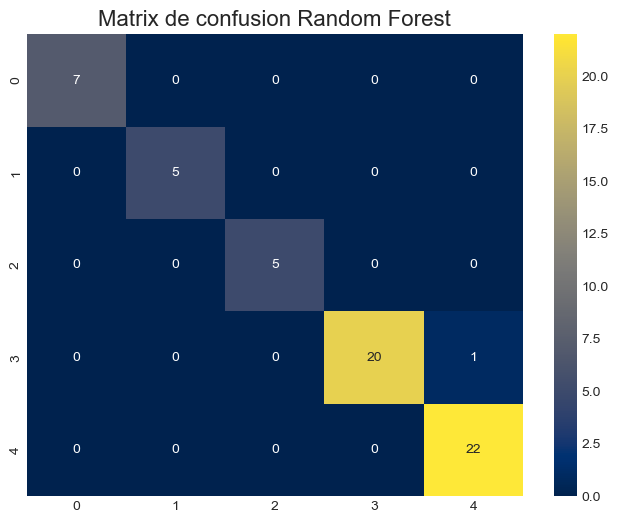

In [154]:
print("\nPuntaje Regresion Logistica Tuneada: \n\n", classification_report(y_test, y_pred_rlt))
cm_RLT=confusion_matrix(y_test, y_pred_rlt)

plt.figure(figsize=(8, 6))
titulo = "Matrix de confusion Random Forest"
sns.heatmap(cm_RLT, annot=True, fmt='d', cmap='cividis', cbar=True)
plt.title(titulo)  # Agregar el título
plt.show

Promedio ROC AUC: 0.9997557997557998


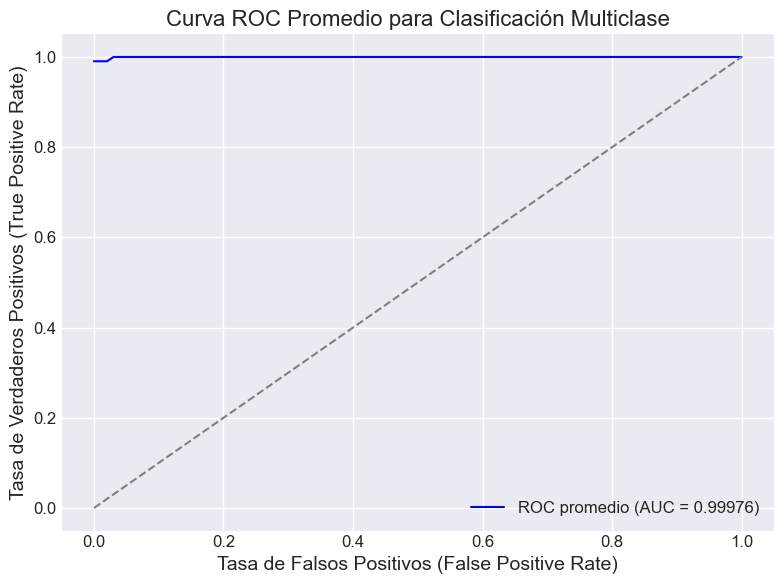

In [167]:
# Inicializar las variables para almacenar las curvas ROC y AUC
tasa_falsos_positivos = dict()
tasa_verdaderos_positivos = dict()
area_bajo_curva = dict()


# Recorrer cada clase y calcular la curva ROC y el AUC
for clase in range(len(RegresionLogisticaMejor.classes_)):
    # Calcular las tasas de falsos positivos (FPR) y verdaderos positivos (TPR) para cada clase
    tasa_falsos_positivos[clase], tasa_verdaderos_positivos[clase], _ = roc_curve(y_test == clase, y_pred_probarlt[:, clase])
    # Calcular el área bajo la curva (AUC) para cada clase
    area_bajo_curva[clase] = auc(tasa_falsos_positivos[clase], tasa_verdaderos_positivos[clase])


# Calcular la media del AUC
mean_roc_auc = np.mean(list(area_bajo_curva.values()))
print("Promedio ROC AUC:", mean_roc_auc)

# Crear el gráfico de la curva ROC promedio
plt.figure(figsize=(8, 6))

# Calcular las tasas de verdaderos positivos y falsos positivos promedio
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, tasa_falsos_positivos[i], tasa_verdaderos_positivos[i]) for i in range(len(RegresionLogisticaMejor.classes_))], axis=0)

# Aplicar un estilo predefinido de Matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
              
# Graficar la curva ROC promedio
plt.plot(mean_fpr, mean_tpr, label=f'ROC promedio (AUC = {mean_roc_auc:.5f})', color='blue')

# Añadir una línea diagonal representando un clasificador aleatorio
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')


# Añadir títulos y etiquetas
plt.title('Curva ROC Promedio para Clasificación Multiclase', fontsize=16)
plt.xlabel('Tasa de Falsos Positivos (False Positive Rate)', fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos (True Positive Rate)', fontsize=14)

# Añadir grid (rejilla)
plt.grid(True)

# Ajustar las etiquetas del eje
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar leyenda
plt.legend(loc='lower right', fontsize=12)

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar la gráfica
plt.show()

### Al ver el area bajo la curva podeos notar que tiene una discriminacion casi perfecta con el promedio de las clases.

 # Caso de prueba

In [168]:
edad = 50
sexo = mapeoCaracteristicas['Sex']['F']
presion = mapeoCaracteristicas['BP']['HIGH']
colesterol = mapeoCaracteristicas['Cholesterol']['NORMAL']
Na_to_K = 15.302

valores_mapeados = pd.DataFrame([[edad, sexo, presion, colesterol, Na_to_K]], columns=x_train.columns)

In [169]:
valores_mapeados

,Age,Sex,BP,Cholesterol,Na_to_K
0,50,0,0,1,15.302


In [170]:
inv_mapeoCaracteristicas = {k: {v: key for key, v in value.items()} for k, value in mapeoCaracteristicas.items()}
inv_mapeoCaracteristicaDrug = {v: k for k, v in mapeoCaracteristicaDrug.items()}


In [174]:
#Prediccion de resultado
y_pred_prueba=RegresionLogisticaMejor.predict(valores_mapeados)
#Extraccion del resultado en el array
y_pred_prueba = y_pred_prueba[0]

#Mapeo de respuesta en el diccionario invertido
resultado = inv_mapeoCaracteristicaDrug[y_pred_prueba]
resultado

'drugY'